<a href="https://colab.research.google.com/github/AbdoBoum/ML/blob/master/hackathon_analyticsvidhya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
 # Get the data file
 train_file_id = '1-zhTccpo9hC3W39bcJ4gGekPCr-0pIWB'
 test_file_id = '1CgJ0ZvSCCxGzQ061vHY87mHSOfNLdPoB'

downloaded = drive.CreateFile({'id': train_file_id}) 
downloaded.GetContentFile('train.csv')  
train_df = pd.read_csv('train.csv')

downloaded = drive.CreateFile({'id': test_file_id}) 
downloaded.GetContentFile('test.csv')  
test_df = pd.read_csv('test.csv')

In [150]:
train_df['source']='train'
test_df['source']='test'
test_df['is_pass']= np.nan

data = pd.concat([train_df, test_df], ignore_index=True)
print(train_df.shape, test_df.shape, data.shape)

(73147, 17) (31349, 17) (104496, 17)


In [107]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73147 entries, 0 to 73146
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         73147 non-null  object 
 1   program_id                 73147 non-null  object 
 2   program_type               73147 non-null  object 
 3   program_duration           73147 non-null  int64  
 4   test_id                    73147 non-null  int64  
 5   test_type                  73147 non-null  object 
 6   difficulty_level           73147 non-null  object 
 7   trainee_id                 73147 non-null  int64  
 8   gender                     73147 non-null  object 
 9   education                  73147 non-null  object 
 10  city_tier                  73147 non-null  int64  
 11  age                        45418 non-null  float64
 12  total_programs_enrolled    73147 non-null  int64  
 13  is_handicapped             73147 non-null  obj

In [0]:
data.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,source
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0.0,train
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1.0,train
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1.0,train
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,NaN,4,N,1.0,1.0,train
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1.0,train


In [0]:
train_df.describe()

,program_duration,test_id,trainee_id,city_tier,age,total_programs_enrolled,trainee_engagement_rating,is_pass
count,73147.000000,73147.000000,73147.000000,73147.000000,45418.000000,73147.000000,73070.000000,73147.000000
mean,128.208676,91.079306,9843.079620,2.246845,36.494033,2.583934,2.395634,0.695408
std,6.889679,51.239048,5703.556093,1.011587,9.041119,1.240816,1.325288,0.460238
min,117.000000,0.000000,1.000000,1.000000,17.000000,1.000000,1.000000,0.000000
25%,121.000000,45.000000,5040.000000,1.000000,28.000000,2.000000,1.000000,0.000000
50%,131.000000,90.000000,9641.000000,2.000000,39.000000,2.000000,2.000000,1.000000
75%,134.000000,135.000000,14552.000000,3.000000,45.000000,3.000000,4.000000,1.000000
max,136.000000,187.000000,20098.000000,4.000000,63.000000,14.000000,5.000000,1.000000


In [0]:
train_df.describe(include='O')

,id,program_id,program_type,test_type,difficulty_level,gender,education,is_handicapped,source
count,73147,73147,73147,73147,73147,73147,73147,73147,73147
unique,73147,22,7,2,4,2,5,2,1
top,15182_96,Y_1,Y,offline,easy,M,High School Diploma,N,train
freq,1,6687,22560,43543,40101,39043,34371,66577,73147


In [0]:
data.apply(lambda x: x.isnull().sum()).sort_values(ascending=False)

age                          39520
is_pass                      31349
trainee_engagement_rating      108
source                           0
difficulty_level                 0
program_id                       0
program_type                     0
program_duration                 0
test_id                          0
test_type                        0
gender                           0
trainee_id                       0
education                        0
city_tier                        0
total_programs_enrolled          0
is_handicapped                   0
id                               0
dtype: int64

In [0]:
train_df[['gender', 'is_pass']].groupby(['gender'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,gender,is_pass
1,M,0.704172
0,F,0.685374


In [0]:
train_df[['education', 'is_pass']].groupby(['education'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,education,is_pass
2,Masters,0.833984
0,Bachelors,0.742509
1,High School Diploma,0.714789
3,Matriculation,0.648592
4,No Qualification,0.583658


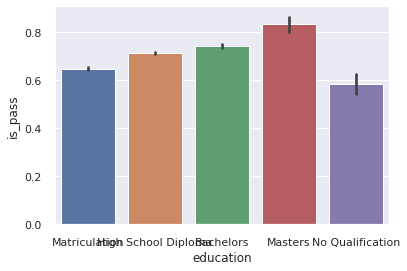

In [0]:
sns.barplot(x="education", y="is_pass", data=train_df)

In [0]:
train_df[['test_type', 'is_pass']].groupby(['test_type'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,test_type,is_pass
1,online,0.779996
0,offline,0.637898


In [0]:
train_df[['difficulty_level', 'is_pass']].groupby(['difficulty_level'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,difficulty_level,is_pass
0,easy,0.737189
1,hard,0.667573
2,intermediate,0.654877
3,vary hard,0.430562


In [0]:
train_df[['city_tier', 'is_pass']].groupby(['city_tier'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,city_tier,is_pass
0,1,0.732702
1,2,0.696994
2,3,0.683879
3,4,0.617070


In [0]:
train_df[['total_programs_enrolled', 'is_pass']].groupby(['total_programs_enrolled'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,total_programs_enrolled,is_pass
0,1,0.717229
9,10,0.700000
1,2,0.698209
3,4,0.695141
2,3,0.693936
12,14,0.692308
6,7,0.646853
5,6,0.645405
4,5,0.628152
7,8,0.603333


In [0]:
train_df[['program_type', 'is_pass']].groupby(['program_type'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,program_type,is_pass
4,X,0.814002
5,Y,0.764096
6,Z,0.720772
1,T,0.698721
2,U,0.625240
3,V,0.585873
0,S,0.546003


In [0]:
train_df[['program_id', 'is_pass']].groupby(['program_id'], as_index=False).mean().sort_values(by='is_pass', ascending=False)

,program_id,is_pass
12,X_1,0.839140
14,X_3,0.801660
13,X_2,0.789406
15,Y_1,0.787049
18,Y_4,0.776203
16,Y_2,0.747937
5,T_4,0.742279
17,Y_3,0.742111
3,T_2,0.740506
4,T_3,0.734315


In [0]:
train_df.dtypes

id                            object
program_id                    object
program_type                  object
program_duration               int64
test_id                        int64
test_type                     object
difficulty_level              object
trainee_id                     int64
gender                        object
education                     object
city_tier                      int64
age                          float64
total_programs_enrolled        int64
is_handicapped                object
trainee_engagement_rating    float64
is_pass                        int64
source                        object
dtype: object

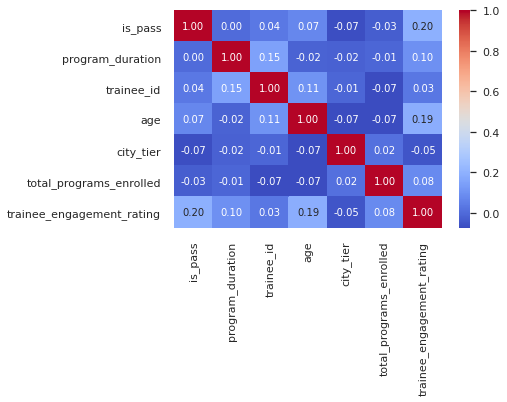

In [0]:
g = sns.heatmap(train_df[["is_pass","program_duration","trainee_id","age","city_tier", "total_programs_enrolled", "trainee_engagement_rating"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [0]:
train_df[['education', 'age']].groupby(['education'], as_index=False).median().sort_values(by='age', ascending=False)

,education,age
2,Masters,45.0
0,Bachelors,43.0
3,Matriculation,40.0
1,High School Diploma,31.0
4,No Qualification,30.0


In [0]:
train_df[['gender', 'age']].groupby(['gender'], as_index=False).median().sort_values(by='age', ascending=False)

,gender,age
0,F,41.0
1,M,35.0


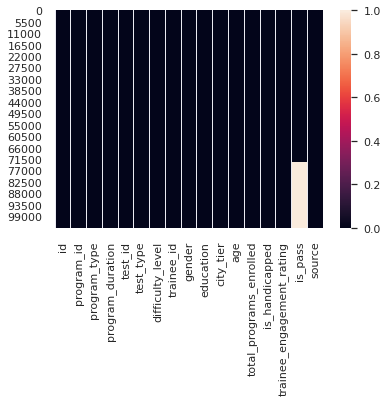

In [0]:
sns.heatmap(data.isnull())

In [0]:
data['age'] = data.groupby(['education', 'gender'])['age'].apply(lambda x: x.fillna(x.median()))
data['trainee_engagement_rating'] = data.groupby(['age','program_duration'])['trainee_engagement_rating'].apply(lambda x: x.fillna(x.median()))

In [0]:
#pd.cut(data['age'], [17, 26, 36, 50, 56, 63]).unique()
data.loc[ data['age'] <= 26, 'age'] = 0
data.loc[(data['age'] > 26) & (data['age'] <= 36), 'age'] = 1
data.loc[(data['age'] > 36) & (data['age'] <= 50), 'age'] = 2
data.loc[(data['age'] > 50), 'age'] = 3

In [0]:
#pd.cut(data['program_duration'], 4).unique()

data.loc[ data['program_duration'] <= 121.75, 'program_duration'] = 0
data.loc[(data['program_duration'] > 121.75) & (data['program_duration'] <= 126.5), 'program_duration'] = 1
data.loc[(data['program_duration'] > 126.25) & (data['program_duration'] <= 131.25), 'program_duration'] = 2
data.loc[ data['program_duration'] > 131.25, 'program_duration'] = 3

In [0]:
train_df = data.loc[data['source']=="train"]

In [140]:
train_df.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,source
0,9389_150,Y_1,Y,3,150,offline,intermediate,9389,M,Matriculation,3,0.0,5,N,1.0,0.0,train
1,16523_44,T_1,T,2,44,offline,easy,16523,F,High School Diploma,4,0.0,2,N,3.0,1.0,train
2,13987_178,Z_2,Z,0,178,online,easy,13987,M,Matriculation,1,2.0,1,N,2.0,1.0,train
3,13158_32,T_2,T,0,32,offline,easy,13158,F,Matriculation,3,2.0,4,N,1.0,1.0,train
4,10591_84,V_3,V,2,84,offline,intermediate,10591,F,High School Diploma,1,2.0,2,N,4.0,1.0,train


In [0]:
data["gender"] = data["gender"].map({"M": 0, "F":1})
data['is_handicapped'] = data['is_handicapped'].map({'N': 0, 'Y': 1})

In [0]:
data['test_type'] = data['test_type'].map({'offline': 0, 'online': 1})

In [0]:
data.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,source
0,9389_150,Y_1,Y,136,150,0,intermediate,9389,0,Matriculation,3,1.0,5,0,1.0,0.0,train
1,16523_44,T_1,T,131,44,0,easy,16523,1,High School Diploma,4,1.0,2,0,3.0,1.0,train
2,13987_178,Z_2,Z,120,178,1,easy,13987,0,Matriculation,1,3.0,1,0,2.0,1.0,train
3,13158_32,T_2,T,117,32,0,easy,13158,1,Matriculation,3,3.0,4,0,1.0,1.0,train
4,10591_84,V_3,V,131,84,0,intermediate,10591,1,High School Diploma,1,3.0,2,0,4.0,1.0,train


In [0]:
data.drop(['program_id', 'test_id', 'trainee_id'],axis=1,inplace=True)

In [0]:
lbl = LabelEncoder()
data['difficulty_level'] = lbl.fit_transform(data['difficulty_level'])
data['education'] = lbl.fit_transform(data['education'])

In [0]:
data = pd.get_dummies(data, columns =['program_type'], drop_first=True)

In [146]:
data.head()

,id,program_duration,test_type,difficulty_level,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,source,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z
0,9389_150,3,0,2,0,3,3,0.0,5,0,1.0,0.0,train,0,0,0,0,1,0
1,16523_44,2,0,0,1,1,4,0.0,2,0,3.0,1.0,train,1,0,0,0,0,0
2,13987_178,0,1,0,0,3,1,2.0,1,0,2.0,1.0,train,0,0,0,0,0,1
3,13158_32,0,0,0,1,3,3,2.0,4,0,1.0,1.0,train,1,0,0,0,0,0
4,10591_84,2,0,2,1,1,1,2.0,2,0,4.0,1.0,train,0,0,1,0,0,0


In [159]:
#data['program_duration'] = StandardScaler().fit_transform(data['program_duration'].values.reshape(-1, 1))
train_df = data.loc[data['source']=="train"]
test_df = data.loc[data['source']=="test"]

train_df.drop('source', axis=1, inplace=True)
test_df.drop('source', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [148]:
train_df.head()

,id,program_duration,test_type,difficulty_level,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z
0,9389_150,0.963723,0,2,0,3,3,0.0,5,0,1.0,0.0,0,0,0,0,1,0
1,16523_44,0.207121,0,0,1,1,4,0.0,2,0,3.0,1.0,1,0,0,0,0,0
2,13987_178,-1.306082,1,0,0,3,1,2.0,1,0,2.0,1.0,0,0,0,0,0,1
3,13158_32,-1.306082,0,0,1,3,3,2.0,4,0,1.0,1.0,1,0,0,0,0,0
4,10591_84,0.207121,0,2,1,1,1,2.0,2,0,4.0,1.0,0,0,1,0,0,0


In [0]:
test_df.head()

,id,program_duration,test_type,difficulty_level,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z
73147,1626_45,0.404862,0,2,1,3,3,3.0,2,0,4.0,NaN,1,0,0,0,0,0
73148,11020_130,0.985181,1,0,0,0,3,3.0,4,0,4.0,NaN,0,0,0,0,1,0
73149,12652_146,-1.191016,1,0,0,3,3,2.0,2,0,3.0,NaN,0,0,0,0,1,0
73150,7038_72,-0.900856,0,3,1,1,1,2.0,2,0,2.0,NaN,0,0,1,0,0,0
73151,888_71,-0.900856,0,2,1,3,3,3.0,2,0,2.0,NaN,0,0,1,0,0,0


In [0]:
x = train_df.drop(['id', 'is_pass'], axis=1)
y = train_df['is_pass']

## Train test split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Logistic Regression

In [162]:
reg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear',penalty="l2")
reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [163]:
reg.score(x_test, y_test)

0.6321257689678742

In [164]:
predicts = reg.predict(x_test)
roc_auc_score(y_test, predicts)

0.6359933459645902

## Naive Bayes

In [165]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [166]:
gaussian.score(x_test, y_test)

0.6531784005468216

In [167]:
predicts = gaussian.predict(x_test)
roc_auc_score(y_test, predicts)

0.6067616930072205

## Decision Tree Classifier

In [168]:
def get_roc_auc(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    predicts = model.predict(x_test)
    return roc_auc_score(val_y, predicts)
'''
for leaf in range(185, 198):
  print(leaf, ': ', get_roc_auc(leaf, x_train, x_test, y_train, y_test))
'''
clf = DecisionTreeClassifier(max_leaf_nodes=186, random_state=0)
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=186,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [0]:
clf.score(x_test, y_test)

0.7166097060833903

In [169]:
predicts = clf.predict(x_test)
roc_auc_score(y_test, predicts)

0.5889135433230994

## KNN

In [170]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [171]:
mse = [1-x for x in cv_scores]
# determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))


NameError: ignored

In [172]:
knn.score(x_test, y_test)

0.701161995898838

In [173]:
predicts = knn.predict(x_test)
roc_auc_score(y_test, predicts)

0.6216658397257111

## Xgboost

In [174]:
parameters = {
              'max_features': [0.8, 0.9],
              'min_samples_leaf' :[0.5,0.9],
              'colsample_bytree' :[0.8,0.9],
              'learning_rate' : [0.01,0.1],
               'min_child_weight': [3,5,7],
              }

xgboost = xgb.XGBClassifier(objective ='reg:logistic' ,random_state=42, n_estimators=100, max_depth = 6)
grid_search2 = GridSearchCV(xgboost, parameters, cv=5,n_jobs=-1)
grid_search2.fit(x_train, y_train)

print(grid_search2.best_params_)
print(grid_search2.best_score_)
'''
xgboost = xgb.XGBClassifier(objective ='reg:logistic'
                            , colsample_bytree = 0.7
                            , learning_rate = 0.01
                            ,max_depth = 6
                            , n_estimators = 100
                            ,random_state=42)
xgboost.fit(x_train,y_train)
'''

{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_features': 0.8, 'min_child_weight': 5, 'min_samples_leaf': 0.5}
0.7241143541896384


"\nxgboost = xgb.XGBClassifier(objective ='reg:logistic'\n                            , colsample_bytree = 0.7\n                            , learning_rate = 0.01\n                            ,max_depth = 6\n                            , n_estimators = 100\n                            ,random_state=42)\nxgboost.fit(x_train,y_train)\n"

In [175]:
predicts = grid_search2.best_estimator_.predict(x_test)
roc_auc_score(y_test, predicts)

0.6061549073355874

##LGBM

In [176]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()                          
lgbm.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [177]:
predicts = lgbm.predict(x_test)
roc_auc_score(y_test, predicts)

0.6039191278363765

## Stacking

In [182]:
from sklearn.ensemble import VotingClassifier

stacking = VotingClassifier(estimators=[
    ('lreg',reg), ('rf', rf),('knn', knn)], voting='hard')
stacking.fit(x_train,y_train)

VotingClassifier(estimators=[('lreg',
                              LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_we...
                                        

In [183]:
predicts = stacking.predict(x_test)
roc_auc_score(y_test, predicts)

0.638358734262169

## Random Forest

In [180]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
rf.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [181]:
predicts = rf.predict(x_test)
roc_auc_score(y_test, predicts)

0.6282842731978677

## Submit

In [0]:
submition = pd.DataFrame({'id': test_df.id})
submition['is_pass'] = stacking.predict(test_df.drop(['id', 'is_pass'], axis=1))

In [0]:
submition.head()

,id,is_pass
73147,1626_45,1.0
73148,11020_130,0.0
73149,12652_146,1.0
73150,7038_72,1.0
73151,888_71,0.0


In [0]:
from google.colab import files
submition.to_csv('submition.csv', index=False) 
files.download('submition.csv')